In [56]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [16]:
data = pd.read_csv('data/jeopardy.csv')
red_data = data.dropna()
red_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [17]:
new_cols = {s:s.strip() for s in red_data.columns}
red_data = red_data.rename(columns=new_cols)

In [18]:
# data = data.rename(columns={' Question': 'question', ' Air Date': 'air_date', ' Round':'round'})
red_data['AirDate'] = pd.to_datetime(red_data['Air Date'])
red_data['year'] = pd.DatetimeIndex(red_data['Air Date']).year  # add year feature
red_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,AirDate,year
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004-12-31,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004-12-31,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,2004-12-31,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004-12-31,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004-12-31,2004


In [19]:
round_list = red_data['Round'].unique()

In [20]:
j_data = red_data[red_data['Round'] == 'Jeopardy!']
dj_data = red_data[red_data['Round'] == 'Double Jeopardy!']
fj_data = red_data[red_data['Round'] == 'Final Jeopardy!']

In [21]:
years = red_data.year.unique()
years

array([2004, 2010, 2000, 2006, 2009, 1996, 2007, 1997, 2002, 2003, 2001,
       1990, 1999, 2008, 2011, 2005, 1998, 2012, 1992, 1986, 1985, 1991,
       1993, 1994, 1988, 1987, 1995, 1984, 1989])

In [24]:
data_dict = {}
for roun in round_list[:-1]:
    roun_data = red_data[red_data['Round'] == roun]
    for year in years:
        data_dict[f'{roun}-{year}'] = list(red_data.Question.values)

In [130]:
corpus = list(data_dict.values())
new_corpus = [(' ').join(doc) for doc in corpus]

In [135]:
def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3, strip digits.
    """
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 2]  # ignore a, an, to, at, be,
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]  # remove any stop words in list of words
    return tokens


def stemwords(words):
    """
    Given a list of tokens/words, return a new list with each word
    stemmed using a PorterStemmer.
    """
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]  # returns list of stemmed words


def tokenizer(text):  # function to split text into a list of stemmed words
    return stemwords(tokenize(text))




In [109]:
n_features = 1000
n_components = 10
n_top_words = 20

In [142]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                                    max_features=n_features,
#                                    stop_words='english')

tfidf_vectorizer = TfidfVectorizer(input='content',
                                   analyzer='word',
                                   tokenizer=tokenizer,
                                   max_features=n_features, stop_words='english')

In [143]:
tfidf = tfidf_vectorizer.fit_transform(new_corpus)

KeyboardInterrupt: 

In [116]:
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

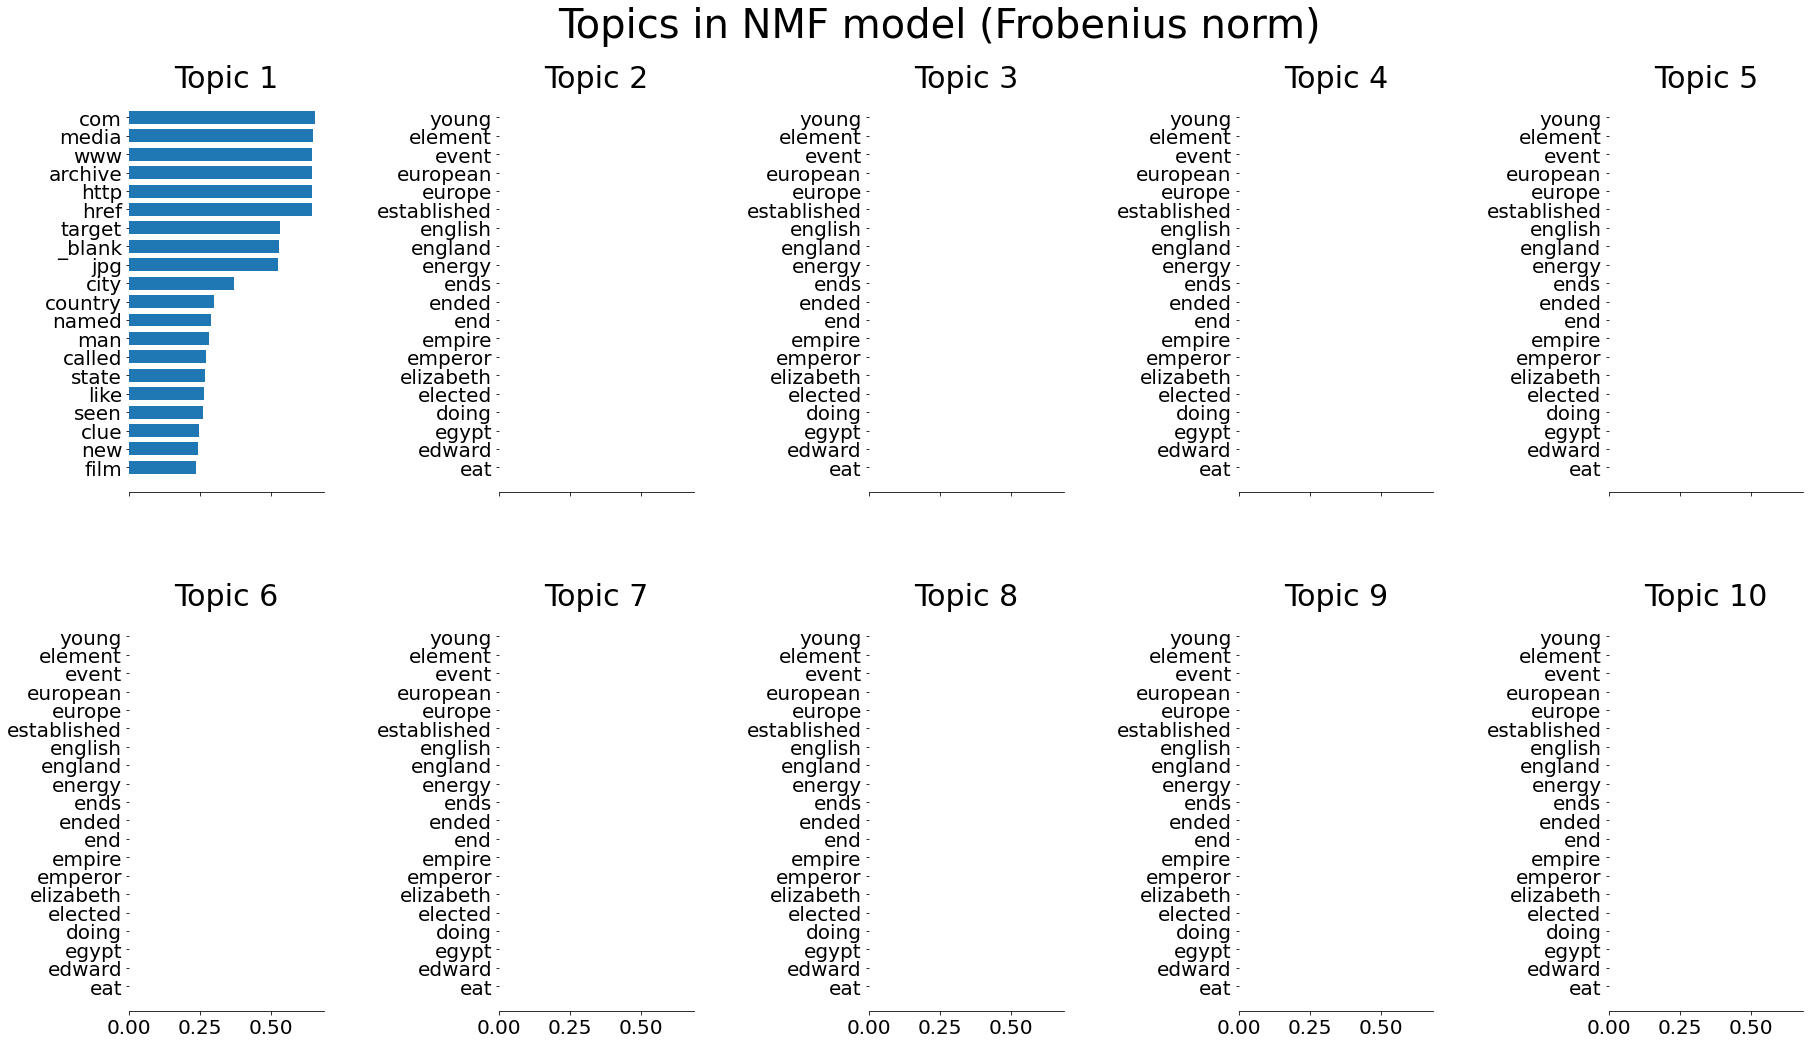

In [120]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')

In [118]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Question 2

## Jeopardy questions grouped by question value

In [25]:
j_data.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer', 'AirDate', 'year'],
      dtype='object')

In [98]:
poss_values = ['$200', '$400', '$600', '$800', '$1000',  '$400', '$800', '$1200', '$1600', '$2000'
              ]

In [101]:
j_data.Value.unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$100', '$300',
       '$500', '$1,200', '$2,200', '$3,000', '$1,500', '$1,600', '$1,800',
       '$1,000', '$1,400', '$700', '$4,800', '$2,500', '$1,300', '$900',
       '$3,600', '$3,200', '$2,800', '$1,100', '$5,000', '$3,389',
       '$5,600', '$3,800', '$5', '$2,600', '$2,300', '$1,263', '$2,400',
       '$6,600', '$4,200', '$2,700', '$350', '$3,400', '$4,000', '$1,700',
       '$250', '$3,989', '$2,100', '$750', '$1,900', '$3,100', '$5,200',
       '$3,500', '$4,600', '$796', '$6,000', '$2,900'], dtype=object)

In [103]:
j_data = j_data[j_data['Value'].isin(poss_values)]

In [104]:
j_data_val = j_data.groupby(by=['Value', 'Category']).agg({'Question': lambda x: ' '.join(x),
                                                           'Answer': lambda x: ' '.join(x)})

In [105]:
j_data_val = j_data.groupby(by=['Value']).agg({'Category': lambda x: ' '.join(x),
                                               'Question': lambda x: ' '.join(x),
                                               'Answer': lambda x: ' '.join(x)})

In [106]:
j_data_val.head()

,Category,Question,Answer
Value,,,
$1000,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES THE CO...,This Asian political party was founded in 1885...,the Congress Party (Wilt) Chamberlain K2 Ethan...
$200,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,"For the last 8 years of his life, Galileo was ...",Copernicus Jim Thorpe Arizona McDonald's John ...
$400,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,Built in 312 B.C. to link Rome & the South of ...,the Appian Way Michael Jordan Washington Crate...
$600,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,In 1000 Rajaraja I of the Cholas battled to ta...,Ceylon (or Sri Lanka) Jim Brown the UV index B...
$800,HISTORY ESPN's TOP 10 ALL-TIME ATHLETES EVERYB...,Karl led the first of these Marxist organizati...,the International (Lou) Gehrig Morocco (Paul) ...


In [107]:
j_data_val['Document'] = j_data_val.Category + ' ' + j_data_val.Question + ' ' + j_data_val.Answer

In [108]:
def normalize_text(cell):
    # Remove punctuation:
    cell = cell.lower()
    cell = cell.translate(str.maketrans('', '', string.punctuation))
    wordnet_lemmatizer = WordNetLemmatizer()
    token_list = word_tokenize(cell)
    
    return ' '.join([wordnet_lemmatizer.lemmatize(w) for w in token_list if w not in stopwords.words('english')])

In [109]:
j_data_val['Norm_Doc'] = j_data_val['Document'].apply(lambda x: normalize_text(x))

In [110]:
j_data_val.shape

(5, 5)

In [111]:
corpus = [text.lower() for text in j_data_val['Norm_Doc'].values]

In [112]:
vectorizer = TfidfVectorizer(stop_words={'english'}, max_df=0.8)
X = vectorizer.fit_transform(corpus)

In [113]:
Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}

In [114]:
NUM_TOPICS = 15

In [115]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online')

In [116]:
lda.fit(X)

/Users/kylebrooks/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)


LatentDirichletAllocation(learning_method='online', n_components=15)

In [117]:
word_topic = lda.components_

In [118]:
lda.transform(X).shape

(5, 15)

In [119]:
from collections import defaultdict
topics = defaultdict(list)
for t in range(NUM_TOPICS):
    # val > 0.5 -> it's part of the topic
    for index, val in enumerate(word_topic[t].argsort()[-15:-1]):#[0,:]):
        topics[t].append(Vocab[val])

In [120]:
topics

defaultdict(list,
            {0: ['hrefhttpwwwjarchivecommedia20060327j13mp3he',
              'tatooine',
              'talus',
              'dewhurst',
              'spacetime',
              'baomer',
              'ratted',
              'elburz',
              'hrefhttpwwwjarchivecommedia20050520j28ajpg',
              'bunraku',
              'antidefamation',
              'tidepools',
              'hrefhttpwwwjarchivecommedia20090715j06jpg',
              'hrefhttpwwwjarchivecommedia20041221j15jpg'],
             1: ['hrefhttpwwwjarchivecommedia20100126j28jpg',
              'hrefhttpwwwjarchivecommedia20070530j17jpg',
              'bowieknifed',
              'wina',
              'nicholsons',
              'gamey',
              'opal',
              'manuel',
              'jello',
              '1847s',
              'tenerife',
              'armentieres',
              'robelike',
              'pregreening'],
             2: ['1169',
              'unglazed',
    

## Double Jeopardy questions grouped by question value

In [122]:
dj_data.Value.unique()

array(['$400', '$800', '$1200', '$2,000', '$1600', '$2000', '$3,200',
       '$5,000', '$200', '$600', '$1,000', '$1000', '$1,500', '$4,800',
       '$1,800', '$1,100', '$3,400', '$3,000', '$4,000', '$6,800',
       '$1,600', '$500', '$1,200', '$1,900', '$3,100', '$700', '$2,800',
       '$8,000', '$6,000', '$2,400', '$12,000', '$3,800', '$2,500',
       '$6,200', '$10,000', '$7,000', '$1,400', '$1,492', '$300',
       '$7,400', '$7,200', '$2,200', '$2,600', '$3,300', '$5,400',
       '$4,500', '$2,100', '$2,127', '$367', '$4,400', '$3,500', '$1,300',
       '$3,600', '$2,900', '$100', '$3,900', '$4,100', '$4,600',
       '$10,800', '$2,300', '$5,600', '$1,111', '$8,200', '$5,800',
       '$750', '$7,500', '$1,700', '$9,000', '$6,100', '$900', '$1,020',
       '$4,700', '$2,021', '$5,200', '$4,200', '$2,001', '$4,637',
       '$3,201', '$3,700', '$2,990', '$5,500', '$14,000', '$6,400',
       '$8,600', '$5', '$6,300', '$6,600', '$8,917', '$9,500', '$1,246',
       '$6,435', '$1,263', '

In [123]:
dj_values = ['$400', '$800', '$1200', '$1500', '$2000']

In [125]:
dj_data = dj_data[dj_data['Value'].isin(dj_values)]

In [132]:
dj_data_val = dj_data.groupby(by=['Value']).agg({'Category': lambda x: ' '.join(x),
                                               'Question': lambda x: ' '.join(x),
                                               'Answer': lambda x: ' '.join(x)})

In [133]:
dj_data_val['Document'] = dj_data_val.Category + ' ' + dj_data_val.Question + ' ' + dj_data_val.Answer

In [134]:
dj_data_val['Norm_Doc'] = dj_data_val['Document'].apply(lambda x: normalize_text(x))

In [136]:
corpus = [text.lower() for text in dj_data_val['Norm_Doc'].values]

In [137]:
vectorizer = TfidfVectorizer(stop_words={'english'}, max_df=0.8)
X = vectorizer.fit_transform(corpus)

Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}

In [138]:
NUM_TOPICS = 15
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online')

In [140]:
lda.fit(X)
word_topic = lda.components_